In [ ]:
# Importing the zipfile to extract the data
import zipfile

# Unzip the data
zep_ref = zipfile.ZipFile("/content/drive/MyDrive/Data Set/Cumin_data_new.zip")
zep_ref.extractall()
zep_ref.close()

In [ ]:
# Inspect the data
import os

# Walk through the directory
for dirpath, dirnames, filenames in os.walk("Cumin_data_new"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'Cumin_data_new'.
There are 6 directories and 0 images in 'Cumin_data_new/val'.
There are 0 directories and 132 images in 'Cumin_data_new/val/Cyminum cuminum'.
There are 0 directories and 113 images in 'Cumin_data_new/val/Mixed Image'.
There are 0 directories and 118 images in 'Cumin_data_new/val/Carum carvi'.
There are 0 directories and 118 images in 'Cumin_data_new/val/Foeniculum vulgare'.
There are 0 directories and 119 images in 'Cumin_data_new/val/Anethum graveolens'.
There are 0 directories and 102 images in 'Cumin_data_new/val/Nigel sativa'.
There are 6 directories and 0 images in 'Cumin_data_new/train'.
There are 0 directories and 1062 images in 'Cumin_data_new/train/Cyminum cuminum'.
There are 0 directories and 907 images in 'Cumin_data_new/train/Mixed Image'.
There are 0 directories and 945 images in 'Cumin_data_new/train/Carum carvi'.
There are 0 directories and 950 images in 'Cumin_data_new/train/Foeniculum vulgare'.
There are 0 direc

In [ ]:
# Get the class names Programatically
import numpy as np
import pathlib

data_dir = pathlib.Path("Cumin_data_new/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['Anethum graveolens' 'Carum carvi' 'Cyminum cuminum' 'Foeniculum vulgare'
 'Mixed Image' 'Nigel sativa']


In [ ]:
# Define directory dataset path
train_dir = "Cumin_data_new/train"
val_dir = "Cumin_data_new/val"
test_dir = "Cumin_data_new/test"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (380, 380)
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = 'categorical',
                                                                 image_size = IMG_SIZE,
                                                                 batch_size = BATCH_SIZE)

valid_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = 1,
                                                                shuffle = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = 1,
                                                                shuffle = True)

Found 5637 files belonging to 6 classes.
Found 702 files belonging to 6 classes.
Found 711 files belonging to 6 classes.


In [ ]:
# Importing the tensorflow library for data augmentation
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotation, zoom etc
data_augmentation = keras.Sequential([
        preprocessing.RandomFlip("horizontal"),
        preprocessing.RandomRotation(0.2),
        preprocessing.RandomZoom(0.2),
        preprocessing.RandomHeight(0.2),
        preprocessing.RandomWidth(0.2),
        #preprocessing.Rescale(1/255.)
])

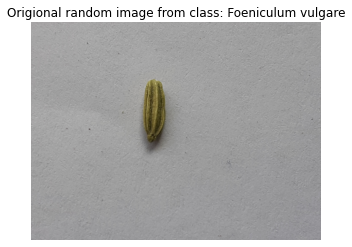

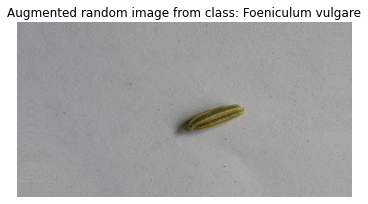

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names)
target_dir = "Cumin_data_new/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Origional random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
plt.figure()
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [ ]:
# Setup the shape and base model, freezing the base model layers
input_shape = (380, 380, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = "input_layer")

# Add in the data augmentation on Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(128, activation="relu")(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(64, activation="relu")(x)

# Put the dense layer on as the output
outputs = layers.Dense(6, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model = keras.Model(inputs, outputs)

71696384/71686520 [==============================] - 1s 0us/step


In [ ]:
# Get the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 380, 380, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling_laye  (None, 1792)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 6)                 10758     
                                                                 
Total params: 17,684,581
Trainable params: 10,758
Non-trainable params: 17,673,823
__________________________________________

In [ ]:
# Compile the model
model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Epoch 1/10
177/177 [==============================] - 561s 3s/step - loss: 0.5944 - accuracy: 0.8228 - val_loss: 0.3453 - val_accuracy: 0.9074
Epoch 2/10
177/177 [==============================] - 460s 3s/step - loss: 0.2565 - accuracy: 0.9296 - val_loss: 0.2550 - val_accuracy: 0.9202
Epoch 3/10
177/177 [==============================] - 433s 2s/step - loss: 0.1892 - accuracy: 0.9496 - val_loss: 0.2281 - val_accuracy: 0.9330
Epoch 4/10
177/177 [==============================] - 452s 2s/step - loss: 0.1547 - accuracy: 0.9576 - val_loss: 0.2230 - val_accuracy: 0.9245
Epoch 5/10
177/177 [==============================] - 412s 2s/step - loss: 0.1278 - accuracy: 0.9659 - val_loss: 0.2106 - val_accuracy: 0.9245
Epoch 6/10
177/177 [==============================] - 396s 2s/step - loss: 0.1180 - accuracy: 0.9684 - val_loss: 0.1967 - val_accuracy: 0.9316
Epoch 7/10
177/177 [==============================] - 388s 2s/step - loss: 0.1023 - accuracy: 0.9718 - val_loss: 0.1861 - val_accuracy: 0.9330

In [ ]:
# Evaluate the model
test_loss,test_acc = model.evaluate(test_data,verbose=1)
print("\n\ntest accuarcy: ",test_acc)

711/711 [==============================] - 56s 79ms/step - loss: 0.1587 - accuracy: 0.9409


test accuarcy:  0.9409282803535461


In [ ]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss", c='r', marker='o', linestyle='dashed')
  plt.plot(epochs, val_loss, label='val_loss',  c='b', marker='*', linestyle='dashed')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy",c='g', marker='o', linestyle='dashed')
  plt.plot(epochs, val_accuracy, label='val_accuracy', c='r', marker='*', linestyle='dashed')
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

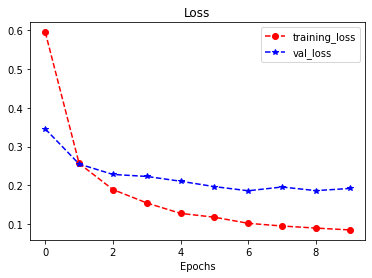

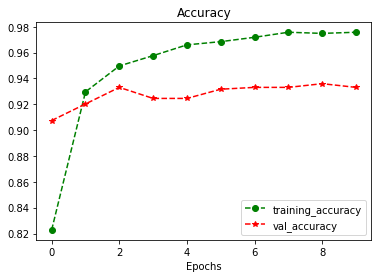

In [ ]:
# Check out our model's training curves
plot_loss_curves(history)

## **Prepare our model for fine tune**

In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/eficientnetb3_cumin_model.h5")

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

846/846 [==============================] - 67s 76ms/step - loss: 0.2821 - accuracy: 0.9113


[0.28207460045814514, 0.911347508430481]

In [ ]:
# Layers in loaded model
model.layers

In [ ]:
# Are these layers trainable?
for layer in model.layers:
  print(layers, layer.trainable)

<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/layers/__init__.py'> True
<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/layers/__init__.py'> True
<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/layers/__init__.py'> False
<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/layers/__init__.py'> True
<module 'keras.api._v2.keras.layers' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/layers/__init__.py'> True


In [ ]:
# What layers are in our base_model (EfficientNetB3) and are they trainable?
for i, layer in enumerate(model.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [ ]:
# How many trainable varialbes are in our base model?
print(len(model.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 14 layers
for layers in base_model.layers[:-14]:
  layers.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
               metrics=['accuracy'])

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block1b_dwconv False
18 block1b_bn False
19 block1b_activation False
20 block1b_se_squeeze False
21 block1b_se_reshape False
22 block1b_se_reduce False
23 block1b_se_expand False
24 block1b_se_excite False
25 block1b_project_conv False
26 block1b_project_bn False
27 block1b_drop False
28 block1b_add False
29 block2a_expand_conv False
30 block2a_expand_bn False
31 block2a_expand_activation False
32 block2a_dwconv_pad False
33 block2a_dwconv False
34 block2a_bn False
35 block2a_activation False
36 block2a_se_squeeze False
37 block2a_se_reshape False
38 block2a_se_reduce False
39 block2a_se_ex

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model.trainable_variables))

14


In [ ]:
# Set EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",  # watch the val loss metric
                                                  patience = 3)          # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,         # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patgience=2,
                                                 verbose=1,          # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Refit the model (same as model expect with more trainable layers)
fine_tune_epochs = 20 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (10 + 10 = 20)

history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data),
                              validation_data=valid_data,
                              validation_steps=len(valid_data),
                              initial_epoch=history.epoch[-1],  # start training from previous last epoch
                              callbacks=[early_stopping, # stop model after X epochs of no improvements
                                         reduce_lr]) # reduce the learning rate after X epochs of no improvements

Epoch 10/20
177/177 [==============================] - 352s 2s/step - loss: 0.0724 - accuracy: 0.9761 - val_loss: 0.2066 - val_accuracy: 0.9444
Epoch 11/20
177/177 [==============================] - 345s 2s/step - loss: 0.0540 - accuracy: 0.9801 - val_loss: 0.1939 - val_accuracy: 0.9430
Epoch 12/20
177/177 [==============================] - 345s 2s/step - loss: 0.0423 - accuracy: 0.9881 - val_loss: 0.1834 - val_accuracy: 0.9416
Epoch 13/20
177/177 [==============================] - 345s 2s/step - loss: 0.0398 - accuracy: 0.9865 - val_loss: 0.1299 - val_accuracy: 0.9587
Epoch 14/20
177/177 [==============================] - 338s 2s/step - loss: 0.0307 - accuracy: 0.9910 - val_loss: 0.1322 - val_accuracy: 0.9644
Epoch 15/20
177/177 [==============================] - 344s 2s/step - loss: 0.0249 - accuracy: 0.9922 - val_loss: 0.1390 - val_accuracy: 0.9601
Epoch 16/20
177/177 [==============================] - 341s 2s/step - loss: 0.0248 - accuracy: 0.9925 - val_loss: 0.1484 - val_accuracy:

In [ ]:
# Evaluate the model
test_loss,test_acc = model.evaluate(test_data,verbose=1)
print("\n\ntest accuarcy: ",test_acc)

711/711 [==============================] - 49s 68ms/step - loss: 0.1277 - accuracy: 0.9606


test accuarcy:  0.9606188535690308


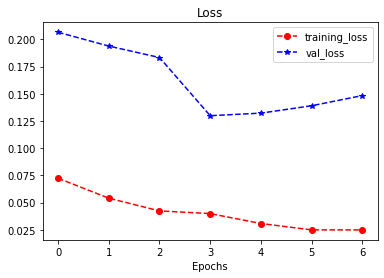

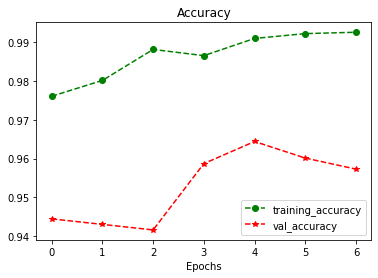

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_fine_tune)

In [ ]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Comapres two TensorFlow History objects.
  """
  # Get origional history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine origional history metrics with new_history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy", c='r', marker='o', linestyle='dashed')
  plt.plot(total_val_acc, label="Val Accuracy", c='b', marker='*', linestyle='dashed')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", c='g', linestyle='dashed')
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss", c='r', marker='o', linestyle='dashed')
  plt.plot(total_val_loss, label="Val Loss", c='g', marker='*', linestyle='dashed')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning", c='b', linestyle='dashed')
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

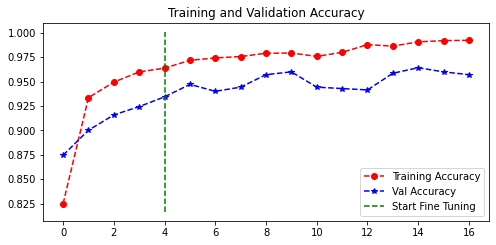

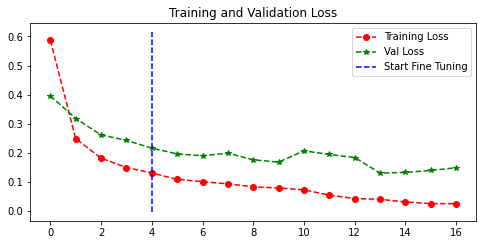

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=5)

## **Making predictions with our trained model**

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

711/711 [==============================] - 56s 74ms/step


In [ ]:
len(test_data)

711

In [ ]:
# How many predictions are there?
len(preds_probs)

711

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(711, 6)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:5]

array([[2.60661163e-05, 3.61235129e-06, 7.76766456e-08, 9.99854207e-01,
        1.15744879e-04, 1.70880568e-07],
       [1.43018469e-01, 3.29728454e-01, 5.17600954e-01, 3.28399008e-03,
        7.77947833e-04, 5.59015665e-03],
       [2.55752564e-03, 1.92977786e-02, 5.41192749e-05, 9.76910114e-01,
        5.92990546e-04, 5.87420189e-04],
       [4.23253179e-02, 1.53337605e-02, 3.47155938e-03, 5.68236937e-05,
        2.51494639e-05, 9.38787401e-01],
       [1.85444427e-04, 1.35332128e-04, 8.43244720e-07, 3.95997704e-05,
        1.29689738e-07, 9.99638677e-01]], dtype=float32)

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([2.6066116e-05, 3.6123513e-06, 7.7676646e-08, 9.9985421e-01,
        1.1574488e-04, 1.7088057e-07], dtype=float32), 6, 0.9999998789424325)

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 6
What prediction probability sample 0 looks like:
 [2.6066116e-05 3.6123513e-06 7.7676646e-08 9.9985421e-01 1.1574488e-04
 1.7088057e-07]
The class with the highest predicted probability by the model for sample 0: 3


In [ ]:
test_data.class_names[0]

'Anethum graveolens'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([3, 2, 3, 5, 5, 1, 0, 0, 0, 2])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

711

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset (Unbatch dataset)
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs

In [ ]:
# Look at the first 10
y_labels[:10]

[1, 3, 5, 3, 0, 1, 3, 1, 2, 2]

In [ ]:
# How many y_labels are there?
len(y_labels)

711

In [ ]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.2039381153305204

## **Let's get visual: making a confusion matrix**

In [ ]:
# Get a list of class names
class_names = test_data.class_names
class_names

['Anethum graveolens',
 'Carum carvi',
 'Cyminum cuminum',
 'Foeniculum vulgare',
 'Mixed Image',
 'Nigel sativa']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

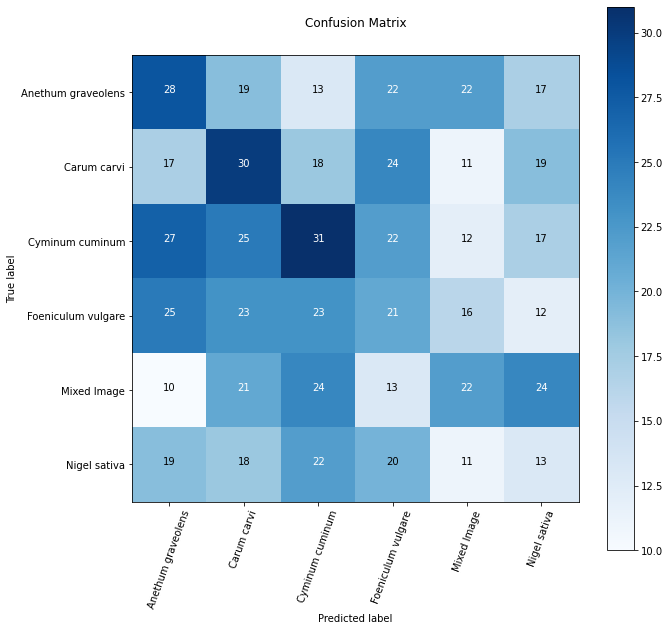

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=10,
                      savefig=True)

## **Let's keep the evaluation train going, time for a classification report**
Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification_report, let's try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.15      0.20      0.17       136
           1       0.26      0.26      0.26       136
           2       0.30      0.23      0.26       166
           3       0.26      0.27      0.26       158
           4       0.16      0.15      0.15       130
           5       0.18      0.18      0.18       120

    accuracy                           0.22       846
   macro avg       0.22      0.21      0.22       846
weighted avg       0.22      0.22      0.22       846



In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.17197452229299365,
  'precision': 0.15168539325842698,
  'recall': 0.19852941176470587,
  'support': 136},
 '1': {'f1-score': 0.2564102564102564,
  'precision': 0.25547445255474455,
  'recall': 0.25735294117647056,
  'support': 136},
 '2': {'f1-score': 0.26262626262626265,
  'precision': 0.29770992366412213,
  'recall': 0.23493975903614459,
  'support': 166},
 '3': {'f1-score': 0.2649842271293375,
  'precision': 0.2641509433962264,
  'recall': 0.26582278481012656,
  'support': 158},
 '4': {'f1-score': 0.15139442231075698,
  'precision': 0.15702479338842976,
  'recall': 0.14615384615384616,
  'support': 130},
 '5': {'f1-score': 0.18333333333333332,
  'precision': 0.18333333333333332,
  'recall': 0.18333333333333332,
  'support': 120},
 'accuracy': 0.21749408983451538,
 'macro avg': {'f1-score': 0.21512050401715677,
  'precision': 0.21822980659921384,
  'recall': 0.2143553460457712,
  'support': 846},
 'weighted avg': {'f1-score': 0.2191549317806564,
  'precision': 0

In [ ]:
class_names[5]

'Nigel sativa'

In [ ]:
classification_report_dict["5"]

{'f1-score': 0.18333333333333332,
 'precision': 0.18333333333333332,
 'recall': 0.18333333333333332,
 'support': 120}

In [ ]:
classification_report_dict["5"]["f1-score"]

0.18333333333333332

In [ ]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Anethum graveolens': 0.17197452229299365,
 'Carum carvi': 0.2564102564102564,
 'Cyminum cuminum': 0.26262626262626265,
 'Foeniculum vulgare': 0.2649842271293375,
 'Mixed Image': 0.15139442231075698,
 'Nigel sativa': 0.18333333333333332}

In [ ]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
# What does our dataframe look like?
f1_scores[:10]

,class_names,f1-score
3,Foeniculum vulgare,0.264984
2,Cyminum cuminum,0.262626
1,Carum carvi,0.256410
5,Nigel sativa,0.183333
0,Anethum graveolens,0.171975
4,Mixed Image,0.151394


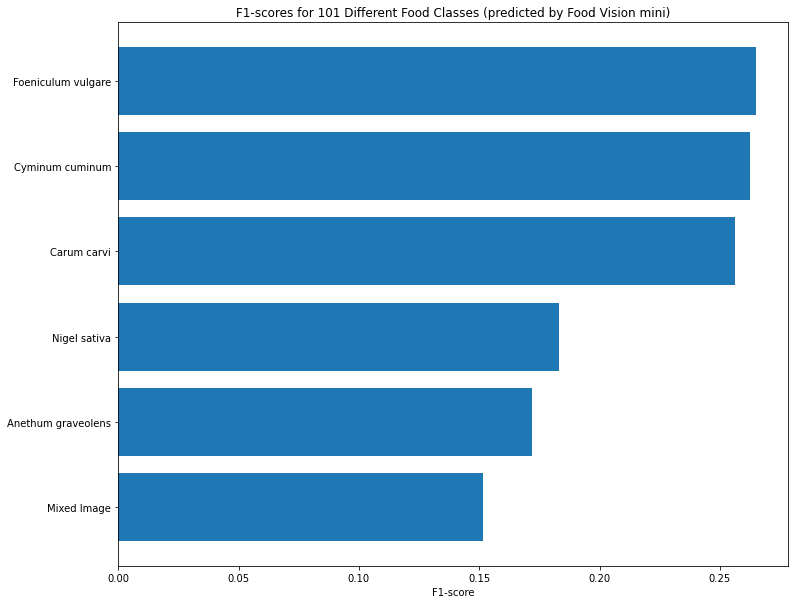

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))
scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes (predicted by Food Vision mini)")
ax.invert_yaxis(); # reverse the order of our plot



# Challenge: add values to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)

## **Visualizing predictions on test images**

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=380, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale piexel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  
  # Scale? Yes/No
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # Don't need to rescale images for EfficientNet models in TensorFlow

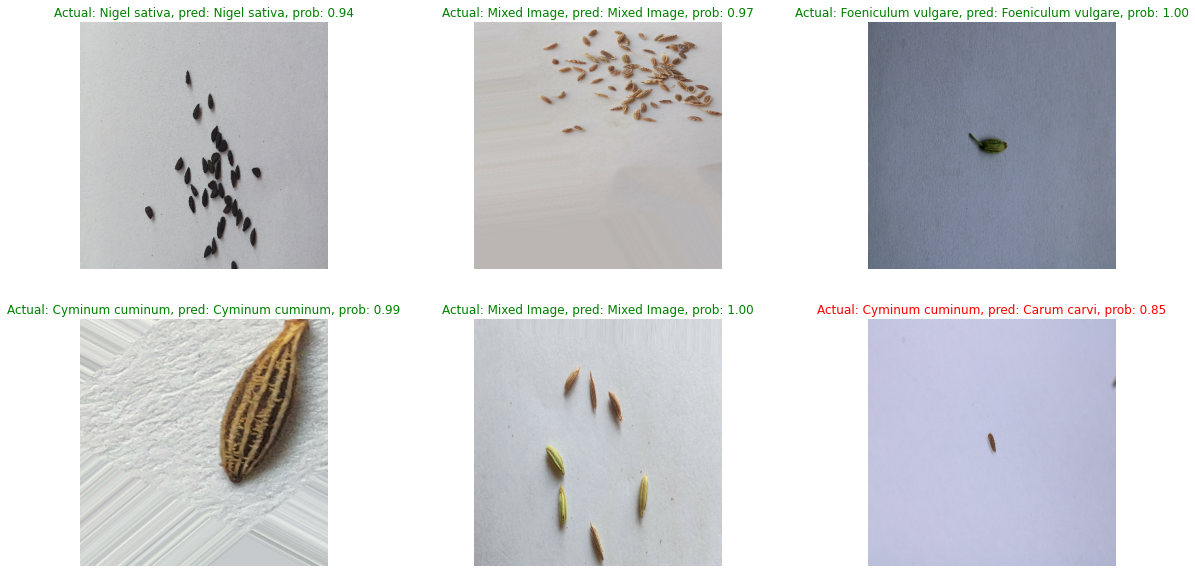

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20,10))

for i in range(6):
  
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded)       # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()]  # get highest prediction probability index and match it class_names list
  # print(pred_prob)
  # print(pred_class)

  # Plot the images
  plt.subplot(2, 3, i+1)
  # print(img)
  plt.imshow(img/255.)
  
  if class_name == pred_class:
    title_color = "g"  # if predicted class matches truth class, make text green
  else:
    title_color = "r"

  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

## **Creating a function to check the file size before and after converting it into tensorflow lite model**

In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
#Define a variable to store our model
MODEL_NAME = "cumin_model_new.h5"

In [ ]:
# Saving our model
model.save(MODEL_NAME)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
convert_bytes(get_file_size(MODEL_NAME), "MB")

File size: 68.267 Megabytes


## **TF LITE MODEL**

In [ ]:
# Convert the model
from tensorflow import lite
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()

In [ ]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_cumin_b4.tflite"

In [ ]:
# Save the model
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

19816800

In [ ]:
convert_bytes(get_file_size(tflite_model_name), "MB")

File size: 18.899 Megabytes
